In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import joblib

import warnings
warnings.filterwarnings('ignore')

In [81]:
df = pd.read_csv('imdb_top_1000.csv')
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [83]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(float)

df['Gross'] = df['Gross'].str.replace(',', '', regex=False).astype(float)

df['Released_Year'] = df['Released_Year'].fillna(df['Released_Year'].median())
df['Runtime'] = df['Runtime'].fillna(df['Runtime'].median())
df['Gross'] = df['Gross'].fillna(df['Gross'].median())
df['Meta_score'] = df['Meta_score'].fillna(df['Meta_score'].median())
df['Certificate'] = df['Certificate'].fillna(df['Certificate'].mode()[0])

df['Target'] = (df['IMDB_Rating'] >= 7.5).astype(int)

imdb_median = df['IMDB_Rating'].median()
df['Target'] = (df['IMDB_Rating'] >= imdb_median).astype(int)

df['Primary_Genre'] = df['Genre'].apply(lambda x: x.split(',')[0])

df.dropna()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Target,Primary_Genre
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994.0,A,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,1,Drama
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972.0,A,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1,Crime
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008.0,UA,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,1,Action
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974.0,A,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,1,Crime
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957.0,U,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,1,Crime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,https://m.media-amazon.com/images/M/MV5BNGEwMT...,Breakfast at Tiffany's,1961.0,A,115.0,"Comedy, Drama, Romance",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,166544,23530892.0,0,Comedy
996,https://m.media-amazon.com/images/M/MV5BODk3Yj...,Giant,1956.0,G,201.0,"Drama, Western",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,34075,23530892.0,0,Drama
997,https://m.media-amazon.com/images/M/MV5BM2U3Yz...,From Here to Eternity,1953.0,Passed,118.0,"Drama, Romance, War",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,43374,30500000.0,0,Drama
998,https://m.media-amazon.com/images/M/MV5BZTBmMj...,Lifeboat,1944.0,U,97.0,"Drama, War",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,23530892.0,0,Drama


In [84]:
df.isnull().sum()

Poster_Link      0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
Target           0
Primary_Genre    0
dtype: int64

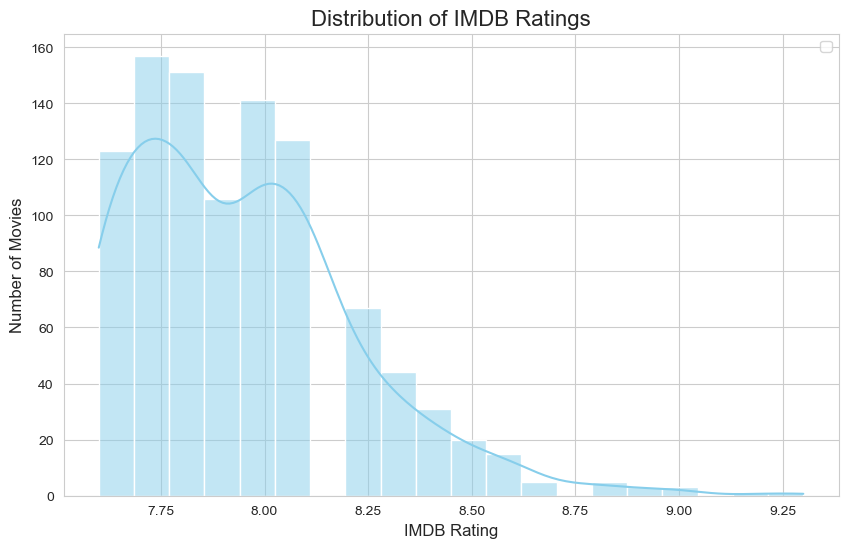

In [85]:
plt.figure(figsize=(10, 6))

sns.histplot(df['IMDB_Rating'], bins=20, kde=True, color='skyblue')

plt.title('Distribution of IMDB Ratings', fontsize=16)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

plt.legend()
plt.show()

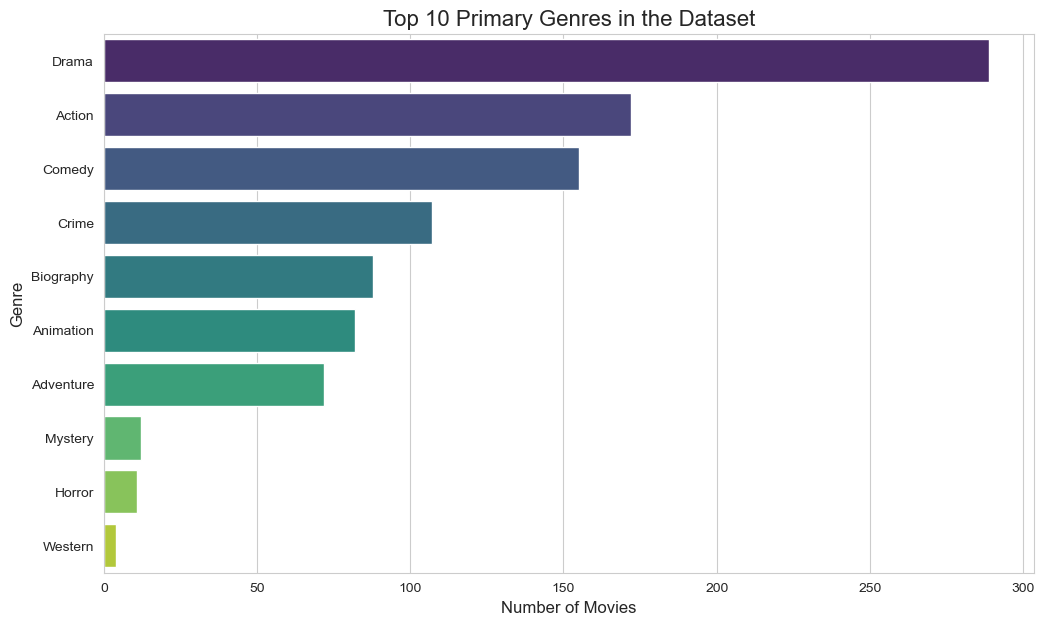

In [86]:
plt.figure(figsize=(12, 7))

top_genres = df['Primary_Genre'].value_counts().nlargest(10)
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')

plt.title('Top 10 Primary Genres in the Dataset', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.show()


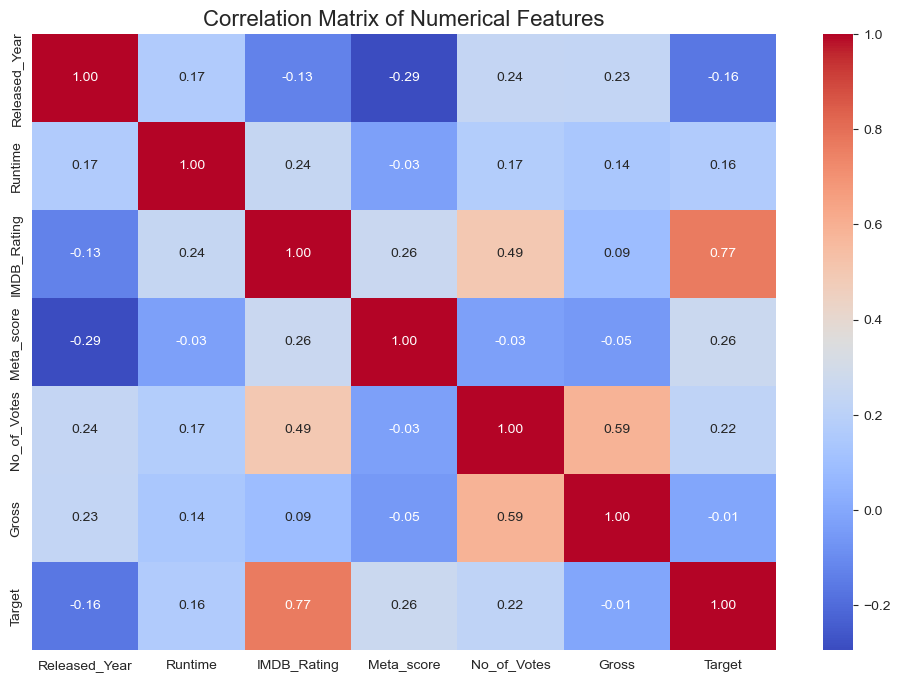

In [87]:
plt.figure(figsize=(12, 8))

numerical_cols = df.select_dtypes(include=np.number)
correlation_matrix = numerical_cols.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Correlation Matrix of Numerical Features', fontsize=16)

plt.show()

In [88]:
features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Primary_Genre']
X = df[features]
y = df['Target']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (700, 6)
Testing set shape: (300, 6)


In [90]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Primary_Genre']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [91]:
# LOGISTIC REGRESSION
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print("Logistic Regression trained.")

Logistic Regression trained.


In [92]:
# GAUSSIAN NAIVE BAYES
nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GaussianNB())])
nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)
print("Gaussian Naive Bayes trained.")

Gaussian Naive Bayes trained.


In [93]:
# HYBRID MODEL
clf1 = LogisticRegression(random_state=42)
clf2 = GaussianNB()
hybrid_model = VotingClassifier(estimators=[('lr', clf1), ('nb', clf2)], voting='soft') 

hybrid_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', hybrid_model)])
hybrid_pipeline.fit(X_train, y_train)
y_pred_hybrid = hybrid_pipeline.predict(X_test)
print("Hybrid Model trained.")

Hybrid Model trained.


In [94]:
all_metrics = {}

model_pipelines = {
    'Logistic Regression': lr_pipeline,
    'Naive Bayes': nb_pipeline,
    'Hybrid Model': hybrid_pipeline
}

def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

y_pred_lr = lr_pipeline.predict(X_test)
y_pred_nb = nb_pipeline.predict(X_test)
y_pred_hybrid = hybrid_pipeline.predict(X_test)

all_metrics['Logistic Regression'] = get_metrics(y_test, y_pred_lr)
all_metrics['Naive Bayes'] = get_metrics(y_test, y_pred_nb)
all_metrics['Hybrid Model'] = get_metrics(y_test, y_pred_hybrid)

comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df.T


print("\nPerformance Metrics Comparison:")
print(comparison_df.round(4))

best_model_name = comparison_df['Accuracy'].idxmax()
print(f"\nThe best performing model is: {best_model_name}")


best_model_pipeline = model_pipelines[best_model_name]

joblib.dump(best_model_pipeline, 'best_model.pkl')


Performance Metrics Comparison:
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.6967     0.7174  0.7719    0.7437
Naive Bayes            0.5600     0.5666  0.9708    0.7155
Hybrid Model           0.5567     0.5651  0.9649    0.7127

The best performing model is: Logistic Regression


['best_model.pkl']

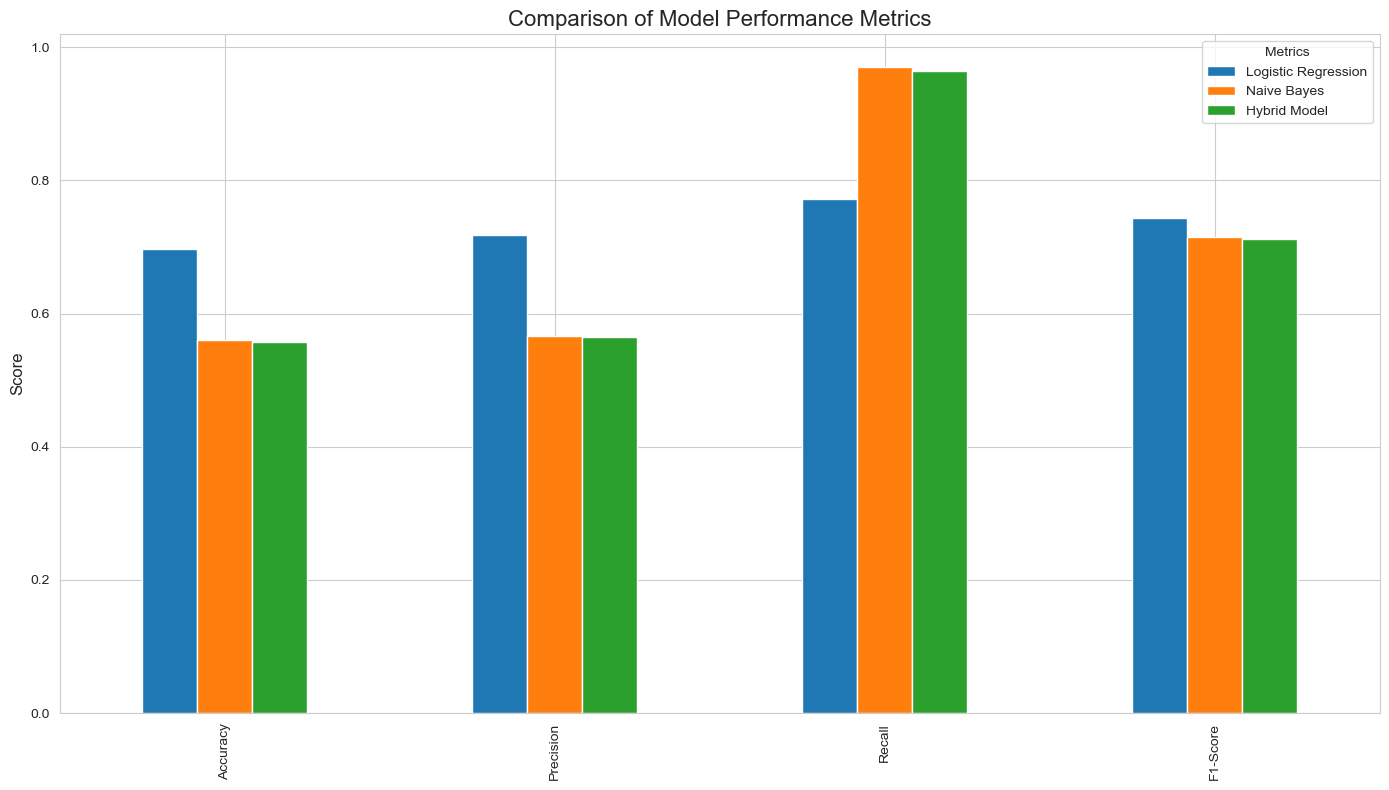

In [95]:
comparison_df.T.plot(kind='bar', figsize=(14, 8))

plt.title('Comparison of Model Performance Metrics', fontsize=16)

plt.ylabel('Score', fontsize=12)
plt.legend(title='Metrics')

plt.tight_layout()
plt.show()

In [96]:
df['soup'] = df['Primary_Genre'] + ' ' + df['Director'] + ' ' + df['Star1']
df['soup'] = df['soup'].fillna('')
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(df.index, index=df['Series_Title']).drop_duplicates()

In [97]:
def get_recommendations(title, model, cosine_sim_matrix):
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim_matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        
        sim_scores = sim_scores[1:21]
        movie_indices = [i[0] for i in sim_scores]
        similar_movies = df.iloc[movie_indices]

        recommendation_features = similar_movies[features]
        
        quality_probs = model.predict_proba(recommendation_features)[:, 1]

        final_recs = similar_movies.copy()
        final_recs['similarity_score'] = [score[1] for score in sim_scores]
        final_recs['predicted_quality'] = quality_probs

        final_recs = final_recs.sort_values(by=['predicted_quality', 'similarity_score'], ascending=False)
        
        return final_recs

    except (KeyError, IndexError):
        return "Movie not found in the dataset."

In [98]:
movie_title = 'Inception'

print(f"\nRecommendations for '{movie_title}'):")

recommendations = get_recommendations(movie_title, best_model_pipeline, cosine_sim)

print(recommendations[['Series_Title', 'IMDB_Rating', 'predicted_quality']].head(5))


Recommendations for 'Inception'):
                Series_Title  IMDB_Rating  predicted_quality
2            The Dark Knight          9.0           0.997503
21              Interstellar          8.6           0.987902
37              The Departed          8.5           0.984726
147  The Wolf of Wall Street          8.2           0.979618
63     The Dark Knight Rises          8.4           0.968179
